In [ ]:
!pip install datasets jiwer huggingface_hub

In [5]:
import huggingface_hub
huggingface_hub.login()

Device set to use cuda
LibriSpeech Clean: 200it [01:41,  1.97it/s]
LibriSpeech Other: 200it [01:36,  2.07it/s]
Common Voice: 0it [00:00, ?it/s]
Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 1it [00:00,  4.42it/s]
Reading metadata...: 16393it [00:00, 47481.85it/s]
Common Voice: 200it [01:13,  2.73it/s]
VoxPopuli: 32it [00:15,  2.13it/s]

VoxPopuli sample error: Missing text in VoxPopuli


VoxPopuli: 41it [00:18,  2.75it/s]

VoxPopuli sample error: Missing text in VoxPopuli


VoxPopuli: 59it [00:26,  1.63it/s]

VoxPopuli sample error: Missing text in VoxPopuli


VoxPopuli: 98it [00:44,  2.31it/s]

VoxPopuli sample error: Missing text in VoxPopuli


VoxPopuli: 158it [01:10,  3.04it/s]

VoxPopuli sample error: Missing text in VoxPopuli


VoxPopuli: 200it [01:30,  2.22it/s]


VoxPopuli sample error: Missing text in VoxPopuli


TEDLIUM: 200it [01:33,  2.15it/s]


Resolving data files:   0%|          | 0/2279 [00:00<?, ?it/s]

GigaSpeech: 200it [01:20,  2.49it/s]
SPGISpeech: 200it [01:36,  2.06it/s]


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Earnings-22: 200it [01:16,  2.62it/s]
AMI: 200it [00:51,  3.91it/s]


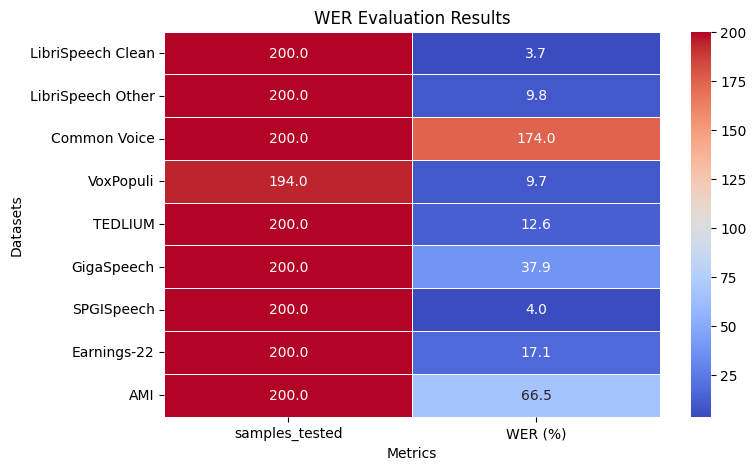

In [8]:
import torch
from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset
import jiwer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Text normalization transform
wer_transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords()
])

def calculate_wer(references, predictions):
    try:
        return jiwer.wer(
            references,
            predictions,
            truth_transform=wer_transform,
            hypothesis_transform=wer_transform
        )
    except:
        return float('inf')

# Initialize model
device = "cuda"
torch_dtype = torch.float32
model_id = "openai/whisper-small"

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id, torch_dtype=torch_dtype, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=device,
    torch_dtype=torch_dtype,
)

DATASET_CONFIG = [
    {"name": "LibriSpeech Clean", "path": "librispeech_asr", "config": "clean", "split": "test", "text_key": "text"},
    {"name": "LibriSpeech Other", "path": "librispeech_asr", "config": "other", "split": "test", "text_key": "text"},
    {"name": "Common Voice", "path": "mozilla-foundation/common_voice_17_0", "config": "en", "split": "test", "text_key": "sentence"},
    {"name": "VoxPopuli", "path": "facebook/voxpopuli", "config": "en", "split": "test", "text_key": "raw_text"},
    {"name": "TEDLIUM", "path": "LIUM/tedlium", "config": "release3", "split": "test", "text_key": "text"},
    {"name": "GigaSpeech", "path": "fixie-ai/gigaspeech", "config":"xl", "split": "test", "text_key": "text"},
    {"name": "SPGISpeech", "path": "kensho/spgispeech", "config":"S", "split": "test", "text_key": "transcript"},
    {"name": "Earnings-22", "path": "distil-whisper/earnings22", "config":"chunked", "split": "test", "text_key": "transcription"},
    {"name": "AMI", "path": "edinburghcstr/ami", "config": "ihm", "split": "test", "text_key": "text"}
]

def evaluate_dataset(dataset_config, max_samples=100):
    try:
        dataset = load_dataset(
            dataset_config["path"],
            dataset_config.get("config"),
            split=dataset_config["split"],
            streaming=True
        ).take(max_samples)
    except Exception as e:
        print(f"Error loading {dataset_config['name']}: {str(e)}")
        return None

    predictions, references = [], []

    for sample in tqdm(dataset, desc=dataset_config["name"]):
        try:
            # Validate audio
            audio = sample["audio"]["array"]
            if audio.size == 0 or audio.ndim != 1:
                raise ValueError("Invalid audio format")

            # Get text with dataset-specific key
            text = sample.get(dataset_config["text_key"])
            if not text or not isinstance(text, str):
                raise ValueError(f"Missing text in {dataset_config['name']}")

            # Get prediction
            result = pipe(
                audio,
                chunk_length_s=30,
                stride_length_s=(4, 2),
                generate_kwargs={"language": "<|en|>", "task": "transcribe"},
            )
            prediction = result["text"].strip()

            references.append(text.strip())
            predictions.append(prediction)

        except Exception as e:
            print(f"{dataset_config['name']} sample error: {str(e)}")
            continue

    if len(references) == 0:
        return None

    return {
        "dataset": dataset_config["name"],
        "samples_tested": len(references),
        "WER (%)": 100 * calculate_wer(references, predictions)
    }

results = []
for config in DATASET_CONFIG:
    result = evaluate_dataset(config, max_samples=200)
    if result:
        results.append(result)

# Display results
if results:
    df = pd.DataFrame(results)
    df.set_index("dataset", inplace=True)
    plt.figure(figsize=(8, 5))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
    plt.title("WER Evaluation Results")
    plt.xlabel("Metrics")
    plt.ylabel("Datasets")
    plt.show()
else:
    print("No results to display")